In [1]:
import pandas as pd

In [2]:
master_df = pd.read_csv('/Users/joomacbook/Desktop/경남 빅데이터 공모전/최종_병합_데이터.csv')

In [3]:
master_df

,x_start,x_end,y_start,y_end,center_lat,center_lon,geometry,buffer_score,people_score,distance_score,dwi_score
0,388802.0,389302.0,312943.0,313443.0,35.417959,127.877274,POINT (127.87727395684394 35.41795864120962),0.00,1.0,0.000000,0.000000
1,377302.0,377802.0,274443.0,274943.0,35.070717,127.751695,POINT (127.7516948580563 35.07071696702705),1.00,1.0,0.000000,1.000000
2,388802.0,389302.0,312443.0,312943.0,35.413452,127.877281,POINT (127.87728070986309 35.413451619196245),0.00,1.0,0.000000,0.000000
3,376802.0,377302.0,274443.0,274943.0,35.070706,127.746213,POINT (127.74621251050583 35.070705686196554),0.75,1.0,0.000000,1.000000
4,376802.0,377302.0,273943.0,274443.0,35.066198,127.746226,POINT (127.7462263809738 35.066198437436405),0.75,1.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
1177,376302.0,376802.0,280443.0,280943.0,35.124781,127.740560,POINT (127.74055985782968 35.12478085583267),0.00,0.0,0.333333,1.000000
1178,388302.0,388802.0,265943.0,266443.0,34.994278,127.872425,POINT (127.87242490641862 34.99427820823108),0.75,0.0,0.333333,0.666667
1179,364802.0,365302.0,293943.0,294443.0,35.246138,127.613811,POINT (127.61381057251423 35.24613842555548),0.00,0.0,1.000000,0.666667
1180,394302.0,394802.0,300943.0,301443.0,35.309835,127.937919,POINT (127.93791885199482 35.30983462478044),0.00,0.0,0.000000,0.666667


In [5]:
master_df['risk_score'] = (
    0.54 * master_df['buffer_score'] +
    0.24 * master_df['people_score'] +
    0.15 * master_df['distance_score'] +
    0.07 * master_df['dwi_score']
)
master_df.head()

,x_start,x_end,y_start,y_end,center_lat,center_lon,geometry,buffer_score,people_score,distance_score,dwi_score,risk_score
0,388802.0,389302.0,312943.0,313443.0,35.417959,127.877274,POINT (127.87727395684394 35.41795864120962),0.00,1.0,0.0,0.0,0.240
1,377302.0,377802.0,274443.0,274943.0,35.070717,127.751695,POINT (127.7516948580563 35.07071696702705),1.00,1.0,0.0,1.0,0.850
2,388802.0,389302.0,312443.0,312943.0,35.413452,127.877281,POINT (127.87728070986309 35.413451619196245),0.00,1.0,0.0,0.0,0.240
3,376802.0,377302.0,274443.0,274943.0,35.070706,127.746213,POINT (127.74621251050583 35.070705686196554),0.75,1.0,0.0,1.0,0.715
4,376802.0,377302.0,273943.0,274443.0,35.066198,127.746226,POINT (127.7462263809738 35.066198437436405),0.75,1.0,0.0,1.0,0.715


In [6]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# 데이터프레임 예시: master_df
# center_lat, center_lon, dwi_score가 포함되어 있어야 함

# Folium 지도 생성 (중심 좌표는 데이터 중앙값 기준)
map_center = [master_df['center_lat'].mean(), master_df['center_lon'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# 히트맵용 데이터 준비 (위도, 경도, 가중치)
heat_data = [
    [row['center_lat'], row['center_lon'], row['dwi_score']] 
    for idx, row in master_df.iterrows()
    if row['risk_score'] > 0  # 0은 시각화에서 제외하면 더 잘 보일 수 있음
]

# 히트맵 추가
HeatMap(heat_data, radius=15, blur=20, max_zoom=13).add_to(m)

# 지도 출력
m

## Quantile of 5

In [10]:
import geopandas as gpd

# 1. 전체 경남 행정구역 경계 불러오기 (GeoDataFrame)
# 예시 파일 경로: '경남_행정경계.shp'
gdf_admin = gpd.read_file('/Users/joomacbook/Desktop/경남 빅데이터 공모전/LARD_ADM_SECT_SGG_경남/LARD_ADM_SECT_SGG_48_202505.shp')

# risk_score 기반 5분위 구간 분류
master_df = master_df[master_df['risk_score'] > 0].sort_values(by='risk_score', ascending=False)
master_df['quantile'] = pd.qcut(master_df['risk_score'], 5, labels=False)

# 컬러 매핑
def get_color(q):
    colors = ['#FFF5F0', '#FCAE91', '#FB6A4A', '#DE2D26', '#A50F15']
    return colors[q]

master_df['color'] = master_df['quantile'].apply(get_color)

# folium 지도 생성
m = folium.Map(location=[master_df['center_lat'].mean(), master_df['center_lon'].mean()], zoom_start=12)
lat_ratio, lon_ratio = 0.00455, 0.00555

for _, row in master_df.iterrows():
    bounds = [
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)]
    ]
    folium.Polygon(
        locations=bounds,
        color=None, fill=True,
        fill_color=row['color'],
        fill_opacity=1.0
    ).add_to(m)

# 행정구역 경계 추가
gdf_boundary = gdf_admin[gdf_admin['SGG_NM'].str.contains('하동군|산청군')].to_crs(epsg=4326)

folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)

m.save("risk_score.html")
print("저장 완료: risk_score.html")

저장 완료: risk_score.html


## Jenks

### Elbow Methods

In [ ]:
import jenkspy
import numpy as np
import matplotlib.pyplot as plt

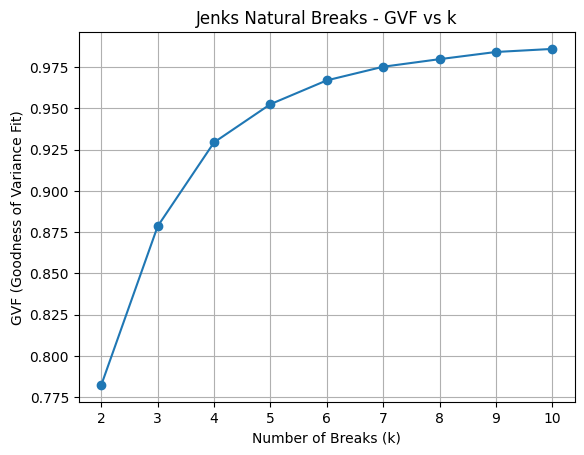

In [12]:
scores = master_df['risk_score'].values
scores = scores[~np.isnan(scores)]  # NaN 제거

k_values = range(2, 11)

sdam = sum((x - np.mean(scores)) ** 2 for x in scores)  # 전체 분산

gvfs = []

for k in k_values:
    breaks = jenkspy.jenks_breaks(scores, n_classes=k)
    ssd = sum(
        (x - np.mean([b for b in scores if b >= breaks[i] and b <= breaks[i+1]])) ** 2
        for i in range(len(breaks) - 1)
        for x in scores if x >= breaks[i] and x <= breaks[i+1]
    )
    gvf = (sdam - ssd) / sdam
    gvfs.append(gvf)

# GVF 그래프 시각화
plt.plot(k_values, gvfs, marker='o')
plt.xlabel('Number of Breaks (k)')
plt.ylabel('GVF (Goodness of Variance Fit)')
plt.title('Jenks Natural Breaks - GVF vs k')
plt.grid(True)
plt.show()


In [16]:
from mapclassify import NaturalBreaks

# Jenks Natural Breaks로 4개 구간으로 나누기
nb = NaturalBreaks(master_df['risk_score'], k=4)

# 구간 라벨 (0~3)을 score_rank로 저장
master_df['risk_rank_4'] = nb.yb

master_df['risk_rank_4'].value_counts()

risk_rank_4
0    448
1    328
2    209
3    183
Name: count, dtype: int64

In [17]:
# Jenks Natural Breaks로 5개 구간으로 나누기
nb = NaturalBreaks(master_df['risk_score'], k=5)

# 구간 라벨 (0~4)을 score_rank로 저장
master_df['risk_rank_5'] = nb.yb

master_df['risk_rank_5'].value_counts()

risk_rank_5
1    326
0    261
3    200
2    198
4    183
Name: count, dtype: int64

In [19]:
# Jenks Natural Breaks로 5개 구간으로 나누기
nb = NaturalBreaks(master_df['risk_score'], k=10)

# 구간 라벨 (0~4)을 score_rank로 저장
master_df['risk_rank_10'] = nb.yb

master_df['risk_rank_10'].value_counts()

risk_rank_10
2    187
1    161
3    139
4    120
8    119
6    118
0    100
5     87
7     83
9     54
Name: count, dtype: int64

In [22]:
import geopandas as gpd

# 1. 전체 경남 행정구역 경계 불러오기 (GeoDataFrame)

# risk_score 기반 5분위 구간 분류
master_df = master_df[master_df['risk_score'] > 0].sort_values(by='risk_score', ascending=False)

# 컬러 매핑
def get_color(q):
    colors = [
    "#08306B",  # 0 - 아주 낮음 (짙은 파랑)
    "#08519C",  # 1
    "#2171B5",  # 2
    "#4292C6",  # 3
    "#6BAED6",  # 4
    "#9ECAE1",  # 5
    "#FCAE91",  # 6
    "#FB6A4A",  # 7
    "#DE2D26",  # 8
    "#A50F15"   # 9 - 아주 높음 (짙은 빨강)
]
    return colors[q]

master_df['color'] = master_df['risk_rank_10'].apply(get_color)

# folium 지도 생성
m = folium.Map(location=[master_df['center_lat'].mean(), master_df['center_lon'].mean()], zoom_start=12)
lat_ratio, lon_ratio = 0.00455, 0.00555

for _, row in master_df.iterrows():
    bounds = [
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)]
    ]
    folium.Polygon(
        locations=bounds,
        color=None, fill=True,
        fill_color=row['color'],
        fill_opacity=1.0
    ).add_to(m)

# 행정구역 경계 추가
gdf_boundary = gdf_admin[gdf_admin['SGG_NM'].str.contains('하동군|산청군')].to_crs(epsg=4326)

folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)

m.save("risk_rank_10.html")
print("저장 완료: risk_rank_10.html")

저장 완료: risk_rank_10.html


In [24]:
bsj = pd.read_csv('/Users/joomacbook/Desktop/경남 빅데이터 공모전/경상남도_비상소화장치_20240630.csv', encoding='cp949')

In [25]:
bsj

,연번,시설번호,시도명,시군구명,시군구코드,소재지도로명주소,소재지지번주소,위도,경도,관할소방서명,관할소방서 전화번호,비고
0,1,비상-01,경상남도,진주시,48170,경상남도 진주시 대신로299번길 7(상대동),경상남도 진주시 상대동 193-1,35.186973,128.116610,진주소방서,055-760-9293,NaN
1,2,비상-02,경상남도,진주시,48170,경상남도 진주시 진양호로547번길 2-1,경상남도 진주시 대안동 8-596,35.193525,128.085195,진주소방서,055-760-9293,NaN
2,3,비상-03,경상남도,진주시,48170,경상남도 진주시 중앙시장길 11-18,경상남도 진주시 대안동 8-405,35.193956,128.085071,진주소방서,055-760-9293,NaN
3,4,비상-04,경상남도,진주시,48170,경상남도 진주시 진양호로555번길 5-3,경상남도 진주시 대안동 8-443,35.194058,128.085805,진주소방서,055-760-9293,NaN
4,5,비상-05,경상남도,진주시,48170,경상남도 진주시 진양호로 551,경상남도 진주시 대안동 8-574,35.193629,128.085644,진주소방서,055-760-9293,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
550,551,가야 비-02,경상남도,합천군,48890,경상남도 합천군 가야면 황산1길 67-12,경상남도 합천군 가야면 황산리 360,35.762943,128.134983,합천소방서,055-930-9293,NaN
551,552,삼가 비-01,경상남도,합천군,48890,경상남도 합천군 삼가면 일부4길 12,경상남도 합천군 삼가면 일부리 908-1,35.412389,128.122946,합천소방서,055-930-9273,NaN
552,553,삼가 비-02,경상남도,합천군,48890,경상남도 합천군 쌍백면 외초1길 32,경상남도 합천군 쌍백면 외초리 616,35.412748,128.170961,합천소방서,055-930-9273,NaN
553,554,삼가 비-03,경상남도,합천군,48890,경상남도 합천군 쌍백면 하안삼리길 66,경상남도 합천군 쌍백면 평구리 953-4,35.441370,128.138054,합천소방서,055-930-9273,NaN


In [26]:
bsj = bsj[bsj['시군구명'].isin(['하동군', '산청군'])]
bsj


,연번,시설번호,시도명,시군구명,시군구코드,소재지도로명주소,소재지지번주소,위도,경도,관할소방서명,관할소방서 전화번호,비고
518,519,하동제1호,경상남도,하동군,48850,경상남도 하동군 하동읍 청년회관길 14-3,경상남도 하동군 하동읍 읍내리 450-4,35.071974,127.747625,하동소방서,055-880-9295,NaN
519,520,하동제2호,경상남도,하동군,48850,경상남도 하동군 하동읍 수박등길 12,경상남도 하동군 하동읍 읍내리 112-2,35.072031,127.752024,하동소방서,055-880-9295,NaN
520,521,하동제3호,경상남도,하동군,48850,경상남도 하동군 하동읍 남당길 42-7,경상남도 하동군 하동읍 광평리 308-1,35.066266,127.746650,하동소방서,055-880-9295,NaN
521,522,하동제4호,경상남도,하동군,48850,경상남도 하동군 옥종면 덕천로 12,경상남도 하동군 옥종면 청룡리 124-26,35.182640,127.880323,하동소방서,055-880-9295,NaN
522,523,하동제5호,경상남도,하동군,48850,경상남도 하동군 금남면 대도길 117-20,경상남도 하동군 금남면 대도리 118,34.931580,127.832020,하동소방서,055-880-9295,NaN
523,524,하동제6호,경상남도,하동군,48850,경상남도 하동군 악양면 하평길 32,경상남도 하동군 봉대리 362-6,35.153265,127.692026,하동소방서,055-880-9295,NaN
524,525,산청 비상소화-1,경상남도,산청군,48860,경상남도 산청군 산청읍 웅석봉로 23-4,경상남도 산청군산청읍산청리 251-2,35.415122,127.875951,산청소방서,055-970-9311,NaN
525,526,산청 비상소화-2,경상남도,산청군,48860,경상남도 산청군 산청읍 웅석봉로 25-5,경상남도 산청군산청읍산청리 251-2,35.414931,127.876216,산청소방서,055-970-9311,NaN
526,527,산청 비상소화-3,경상남도,산청군,48860,경상남도 산청군 산청읍 웅석봉로 23,경상남도 산청군산청읍산청리 348-4,35.414814,127.875979,산청소방서,055-970-9311,NaN
527,528,산청 비상소화-4,경상남도,산청군,48860,경상남도 산청군 산청읍 웅석봉로 23-5,경상남도 산청군산청읍산청리 251-2,35.414912,127.876408,산청소방서,055-970-9311,NaN


## 비상소화장치 위치 추가

In [45]:
import geopandas as gpd

# 1. 전체 경남 행정구역 경계 불러오기 (GeoDataFrame)

# risk_score 기반 5분위 구간 분류
master_df = master_df[master_df['risk_score'] > 0].sort_values(by='risk_score', ascending=False)

# 컬러 매핑
def get_color(q):
    colors = [
    "#08306B",  # 0 - 아주 낮음 (짙은 파랑)
    "#08519C",  # 1
    "#2171B5",  # 2
    "#4292C6",  # 3
    "#6BAED6",  # 4
    "#9ECAE1",  # 5
    "#FCAE91",  # 6
    "#FB6A4A",  # 7
    "#DE2D26",  # 8
    "#A50F15"   # 9 - 아주 높음 (짙은 빨강)
]
    return colors[q]

master_df['color'] = master_df['risk_rank_10'].apply(get_color)

# folium 지도 생성
m = folium.Map(location=[master_df['center_lat'].mean(), master_df['center_lon'].mean()], zoom_start=12)
lat_ratio, lon_ratio = 0.00455, 0.00555

# 1. 히트맵(격자 시각화) 그룹
heatmap_layer = folium.FeatureGroup(name='🔥 Risk Heatmap (격자)').add_to(m)

lat_ratio, lon_ratio = 0.00455, 0.00555

for _, row in master_df.iterrows():
    bounds = [
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)]
    ]
    folium.Polygon(
        locations=bounds,
        color=None,
        fill=True,
        fill_color=row['color'],
        fill_opacity=1.0
    ).add_to(heatmap_layer)

# 행정구역 경계 추가
gdf_boundary = gdf_admin[gdf_admin['SGG_NM'].str.contains('하동군|산청군')].to_crs(epsg=4326)

folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)

# 🔥 비상소화장치 위치 표시
for _, row in bsj.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3,
        color='black',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.9,
        popup='비상소화장치'
    ).add_to(m)


m.save("risk_rank_10_with_BSJ.html")
print("저장 완료: risk_rank_10_with_BSJ.html")

저장 완료: risk_rank_10_with_BSJ.html


In [77]:
sys = pd.read_csv('/Users/joomacbook/Desktop/경남 빅데이터 공모전/경상남도_소방용수시설 현황_20230630.csv', encoding='cp949')

In [78]:
sys = sys[sys['시군구명'].isin(['하동군', '산청군'])]
sys


,연번,시설번호(자체 관리번호),수리형식,시도명,시군구명,시군코드,소재지도로명주소,소재지지번주소,위도,경도,...,보호틀유무,사용가능여부,설치연도,배관깊이(미터),출수압력,배관지름(밀리미터),관할소방서명,전화번호,소방용수표지설치,설치주체
7171,7172,1-A-1-1,지상식,경상남도,하동군,48850,경상남도 하동군 하동읍 중앙로 79,경상남도 하동군 하동읍 읍내리 1051,35.071778,127.744044,...,Y,Y,2002.0,5.0,4.5,65.0,하동소방서,055-880-9362,설치,경상남도
7172,7173,1-A-1-2,지상식,경상남도,하동군,48850,경상남도 하동군 하동읍 동광길 1,경상남도 하동군 하동읍 읍내리 408-4,35.070869,127.748685,...,Y,Y,1985.0,4.2,3.5,65.0,하동소방서,055-880-9362,설치,경상남도
7173,7174,1-A-1-3,지상식,경상남도,하동군,48850,경상남도 하동군 하동읍 하마길 64-7,경상남도 하동군 하동읍 읍내리 374-2,35.070805,127.750271,...,Y,Y,1981.0,5.0,3.0,65.0,하동소방서,055-880-9362,설치,경상남도
7174,7175,1-A-1-4,지상식,경상남도,하동군,48850,경상남도 하동군 하동읍 경서대로 217,경상남도 하동군 하동읍 비파리 633-2,35.0718,127.7561,...,Y,Y,1997.0,4.5,5.0,65.0,하동소방서,055-880-9362,설치,경상남도
7175,7176,1-A-1-5,지상식,경상남도,하동군,48850,경상남도 하동군 하동읍 향교 1길 52,경상남도 하동군 하동읍 읍내리 1294-5,35.06423,127.748131,...,Y,Y,1985.0,5.0,3.0,65.0,하동소방서,055-880-9362,설치,경상남도
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7472,7473,산악-1-23,지상식,경상남도,산청군,48860,경상남도 산청군 시천면 남명로 109,경상남도 산청군 시천면 원리 237-1,35.27283086,127.8311067,...,N,Y,2020.0,0.5,4.0,130.0,산청소방서,055-970-9306,미설치,지자체
7473,7474,산악-1-24,지상식,경상남도,산청군,48860,경상남도 산청군 시천면 송하중태길 39-4,경상남도 산청군 시천면 천평리 520,35.27431874,127.8400809,...,N,Y,2020.0,0.5,3.0,130.0,산청소방서,055-970-9306,미설치,지자체
7474,7475,산악-1-25,지상식,경상남도,산청군,48860,경상남도 산청군 시천면 남명로 200번길 13,경상남도 산청군 시천면 사리 930-7,35.27684488,127.8393909,...,Y,Y,2012.0,0.5,3.0,130.0,산청소방서,055-970-9306,설치,지자체
7475,7476,산악-1-26,지상식,경상남도,산청군,48860,경상남도 산청군 시천면 지리산대로 1846번길 77,경상남도 산청군 시천면 천평리 125,35.2783081,127.8388964,...,N,Y,2021.0,0.5,4.5,130.0,산청소방서,055-970-9306,미설치,지자체


In [79]:
# 수리형식이 '지하식' 또는 '지상식'인 데이터만 필터링
sys = sys[sys['수리형식'].isin(['지하식', '지상식'])]

In [80]:
sys

,연번,시설번호(자체 관리번호),수리형식,시도명,시군구명,시군코드,소재지도로명주소,소재지지번주소,위도,경도,...,보호틀유무,사용가능여부,설치연도,배관깊이(미터),출수압력,배관지름(밀리미터),관할소방서명,전화번호,소방용수표지설치,설치주체
7171,7172,1-A-1-1,지상식,경상남도,하동군,48850,경상남도 하동군 하동읍 중앙로 79,경상남도 하동군 하동읍 읍내리 1051,35.071778,127.744044,...,Y,Y,2002.0,5.0,4.5,65.0,하동소방서,055-880-9362,설치,경상남도
7172,7173,1-A-1-2,지상식,경상남도,하동군,48850,경상남도 하동군 하동읍 동광길 1,경상남도 하동군 하동읍 읍내리 408-4,35.070869,127.748685,...,Y,Y,1985.0,4.2,3.5,65.0,하동소방서,055-880-9362,설치,경상남도
7173,7174,1-A-1-3,지상식,경상남도,하동군,48850,경상남도 하동군 하동읍 하마길 64-7,경상남도 하동군 하동읍 읍내리 374-2,35.070805,127.750271,...,Y,Y,1981.0,5.0,3.0,65.0,하동소방서,055-880-9362,설치,경상남도
7174,7175,1-A-1-4,지상식,경상남도,하동군,48850,경상남도 하동군 하동읍 경서대로 217,경상남도 하동군 하동읍 비파리 633-2,35.0718,127.7561,...,Y,Y,1997.0,4.5,5.0,65.0,하동소방서,055-880-9362,설치,경상남도
7175,7176,1-A-1-5,지상식,경상남도,하동군,48850,경상남도 하동군 하동읍 향교 1길 52,경상남도 하동군 하동읍 읍내리 1294-5,35.06423,127.748131,...,Y,Y,1985.0,5.0,3.0,65.0,하동소방서,055-880-9362,설치,경상남도
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7471,7472,산악-1-22,지상식,경상남도,산청군,48860,경상남도 산청군 시천면 남명로 159번길 11,경상남도 산청군 시천면 원리 157-12,35.27641498,127.831215,...,N,Y,2020.0,0.5,4.0,130.0,산청소방서,055-970-9306,미설치,지자체
7472,7473,산악-1-23,지상식,경상남도,산청군,48860,경상남도 산청군 시천면 남명로 109,경상남도 산청군 시천면 원리 237-1,35.27283086,127.8311067,...,N,Y,2020.0,0.5,4.0,130.0,산청소방서,055-970-9306,미설치,지자체
7473,7474,산악-1-24,지상식,경상남도,산청군,48860,경상남도 산청군 시천면 송하중태길 39-4,경상남도 산청군 시천면 천평리 520,35.27431874,127.8400809,...,N,Y,2020.0,0.5,3.0,130.0,산청소방서,055-970-9306,미설치,지자체
7474,7475,산악-1-25,지상식,경상남도,산청군,48860,경상남도 산청군 시천면 남명로 200번길 13,경상남도 산청군 시천면 사리 930-7,35.27684488,127.8393909,...,Y,Y,2012.0,0.5,3.0,130.0,산청소방서,055-970-9306,설치,지자체


## 비소장 + 소용시

In [52]:
import geopandas as gpd

# 1. 전체 경남 행정구역 경계 불러오기 (GeoDataFrame)

# risk_score 기반 5분위 구간 분류
master_df = master_df[master_df['risk_score'] > 0].sort_values(by='risk_score', ascending=False)

# 컬러 매핑
def get_color(q):
    colors = [
    "#08306B",  # 0 - 아주 낮음 (짙은 파랑)
    "#08519C",  # 1
    "#2171B5",  # 2
    "#4292C6",  # 3
    "#6BAED6",  # 4
    "#9ECAE1",  # 5
    "#FCAE91",  # 6
    "#FB6A4A",  # 7
    "#DE2D26",  # 8
    "#A50F15"   # 9 - 아주 높음 (짙은 빨강)
]
    return colors[q]

master_df['color'] = master_df['risk_rank_10'].apply(get_color)

# folium 지도 생성
m = folium.Map(location=[master_df['center_lat'].mean(), master_df['center_lon'].mean()], zoom_start=12)
lat_ratio, lon_ratio = 0.00455, 0.00555

# 1. 히트맵(격자 시각화) 그룹
heatmap_layer = folium.FeatureGroup(name='🔥 Risk Heatmap (격자)').add_to(m)

lat_ratio, lon_ratio = 0.00455, 0.00555

for _, row in master_df.iterrows():
    bounds = [
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)]
    ]
    folium.Polygon(
        locations=bounds,
        color=None,
        fill=True,
        fill_color=row['color'],
        fill_opacity=1.0
    ).add_to(heatmap_layer)

# 행정구역 경계 추가
gdf_boundary = gdf_admin[gdf_admin['SGG_NM'].str.contains('하동군|산청군')].to_crs(epsg=4326)

folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)

# 🔥 비상소화장치 위치 표시
for _, row in bsj.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.9,
        popup='비상소화장치'
    ).add_to(m)

# 🔥 소방용수시설 위치 표시
for _, row in sys.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.9,
        popup='소방용수시설'
    ).add_to(m)

m.save("risk_rank_10_with_BSJ&SYS.html")
print("저장 완료: risk_rank_10_with_BSJ&SYS.html")

저장 완료: risk_rank_10_with_BSJ&SYS.html


## 비소장 + 소용시 + 소방서

In [46]:
ppippo = pd.read_csv('/Users/joomacbook/Desktop/경남 빅데이터 공모전/전국_소방서XY좌표_중복제외.csv')
ppippo

,번호,소방서 및 안전센터명,주소,상위 본부명,전화번호,Y,X,유형,등록일
0,1,수성소방서-수성-119 안전센터,대구광역시 수성구 들안로60길 30,대구소방안전본부,053-741-2119,35.856757,128.620850,119안전센터,2018-03-17
1,2,수성소방서-황금-119 안전센터,대구광역시 수성구 동대구로12길 41,대구소방안전본부,053-764-0119,35.835493,128.626425,119안전센터,2018-03-17
2,3,수성소방서-만촌-119 안전센터,대구광역시 수성구 달구벌대로 2658,대구소방안전본부,053-752-0119,35.855340,128.652108,119안전센터,2018-03-17
3,5,북부소방서_대구-산격-119 안전센터,대구광역시 북구 유통단지로8길 88,대구소방안전본부,053-350-5790,35.906077,128.614247,119안전센터,2018-03-17
4,6,북부소방서_대구-무태-119 안전센터,대구광역시 북구 호국로43길 21,대구소방안전본부,053-350-5780,35.920917,128.596901,119안전센터,2018-03-17
...,...,...,...,...,...,...,...,...,...
1019,995,하남소방서,경기도 하남시 대청로 76,경기재난안전본부,031-799-4212,37.539898,127.220432,소방서,2018-03-17
1020,996,제천소방서,충청북도 제천시 신죽하로 164 제천소방서,충북소방본부,043-641-7114,37.160590,128.212800,소방서,2018-03-17
1021,998,송탄소방서,경기도 평택시 경기대로 1627,경기재난안전본부,031-685-8212,37.089811,127.062145,소방서,2018-03-17
1022,999,군포소방서,경기도 군포시 고산로 429 군포소방서,경기재난안전본부,031-479-8212,37.352596,126.927119,소방서,2018-03-17


In [53]:
import geopandas as gpd

# 1. 전체 경남 행정구역 경계 불러오기 (GeoDataFrame)

# risk_score 기반 5분위 구간 분류
master_df = master_df[master_df['risk_score'] > 0].sort_values(by='risk_score', ascending=False)

# 컬러 매핑
def get_color(q):
    colors = [
    "#08306B",  # 0 - 아주 낮음 (짙은 파랑)
    "#08519C",  # 1
    "#2171B5",  # 2
    "#4292C6",  # 3
    "#6BAED6",  # 4
    "#9ECAE1",  # 5
    "#FCAE91",  # 6
    "#FB6A4A",  # 7
    "#DE2D26",  # 8
    "#A50F15"   # 9 - 아주 높음 (짙은 빨강)
]
    return colors[q]

master_df['color'] = master_df['risk_rank_10'].apply(get_color)

# folium 지도 생성
m = folium.Map(location=[master_df['center_lat'].mean(), master_df['center_lon'].mean()], zoom_start=12)
lat_ratio, lon_ratio = 0.00455, 0.00555

# 1. 히트맵(격자 시각화) 그룹
heatmap_layer = folium.FeatureGroup(name='🔥 Risk Heatmap (격자)').add_to(m)

lat_ratio, lon_ratio = 0.00455, 0.00555

for _, row in master_df.iterrows():
    bounds = [
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)]
    ]
    folium.Polygon(
        locations=bounds,
        color=None,
        fill=True,
        fill_color=row['color'],
        fill_opacity=1.0
    ).add_to(heatmap_layer)

# 행정구역 경계 추가
gdf_boundary = gdf_admin[gdf_admin['SGG_NM'].str.contains('하동군|산청군')].to_crs(epsg=4326)

folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)

# 🔥 비상소화장치 위치 표시
for _, row in bsj.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.9,
        popup='비상소화장치'
    ).add_to(m)

# 🔥 소방용수시설 위치 표시
for _, row in sys.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.9,
        popup='소방용수시설'
    ).add_to(m)

# 🔥 소방서 위치 표시
for _, row in ppippo.iterrows():
    folium.CircleMarker(
        location=[row['Y'], row['X']],
        radius=3,
        color='brown',
        fill=True,
        fill_color='brown',
        fill_opacity=0.9,
        popup='소방센터'
    ).add_to(m)

m.save("risk_rank_10_with_BSJ&SYS&SBS.html")
print("저장 완료: risk_rank_10_with_BSJ&SYS&SBS.html")

저장 완료: risk_rank_10_with_BSJ&SYS&SBS.html


## Test

In [83]:
# 지도 초기화
m = folium.Map(location=[master_df['center_lat'].mean(), master_df['center_lon'].mean()], zoom_start=12)
lat_ratio, lon_ratio = 0.00455, 0.00555

# 컬러 매핑
def get_color(q):
    colors = [
        "#08306B", "#08519C", "#2171B5", "#4292C6", "#6BAED6",
        "#9ECAE1", "#FCAE91", "#FB6A4A", "#DE2D26", "#A50F15"
    ]
    return colors[q]

master_df = master_df[master_df['risk_score'] > 0].sort_values(by='risk_score', ascending=False)
master_df['color'] = master_df['risk_rank_10'].apply(get_color)

# 🔥 히트맵 격자
heatmap_layer = folium.FeatureGroup(name='🔥 Risk Heatmap (격자)').add_to(m)
for _, row in master_df.iterrows():
    bounds = [
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] + (lon_ratio / 2)],
        [row['center_lat'] + (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)],
        [row['center_lat'] - (lat_ratio / 2), row['center_lon'] - (lon_ratio / 2)]
    ]
    folium.Polygon(
        locations=bounds,
        color=None,
        fill=True,
        fill_color=row['color'],
        fill_opacity=1.0
    ).add_to(heatmap_layer)

# ✅ 행정구역 경계
gdf_boundary = gdf_admin[gdf_admin['SGG_NM'].str.contains('하동군|산청군')].to_crs(epsg=4326)
folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)

# ✅ 비상소화장치
bsj_layer = folium.FeatureGroup(name='🟡 비상소화장치').add_to(m)
for _, row in bsj.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.9,
        popup='비상소화장치'
    ).add_to(bsj_layer)

# ✅ 소방용수시설
sys_layer = folium.FeatureGroup(name='🟣 소방용수시설').add_to(m)
for _, row in sys.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.9,
        popup='소방용수시설'
    ).add_to(sys_layer)

# ✅ 소방서
sbs_layer = folium.FeatureGroup(name='🚒 소방센터').add_to(m)
for _, row in ppippo.iterrows():
    folium.Marker(
        location=[row['Y'], row['X']],
        icon=folium.Icon(color='red', icon='ambulance', prefix='fa'),
        popup='소방센터'
    ).add_to(sbs_layer)

# ✅ 범례 (리스크 색상 의미)
legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 210px;
    height: 290px;  /* 기존보다 늘렸습니다 */
    z-index:9999;
    background-color: white;
    border:2px solid grey;
    padding: 10px;
    font-size:14px;
    line-height: 1.4;
    overflow: hidden;
">
<b>🔥 산불피해 취약도 범례</b><br>
<i style="background:#A50F15; width:18px; height:18px; float:left; margin-right:5px; display:inline-block;"></i> 매우 높음<br>
<i style="background:#DE2D26; width:18px; height:18px; float:left; margin-right:5px; display:inline-block;"></i> 높음<br>
<i style="background:#FB6A4A; width:18px; height:18px; float:left; margin-right:5px; display:inline-block;"></i> 중상<br>
<i style="background:#FCAE91; width:18px; height:18px; float:left; margin-right:5px; display:inline-block;"></i> 중간<br>
<i style="background:#9ECAE1; width:18px; height:18px; float:left; margin-right:5px; display:inline-block;"></i> 중하<br>
<i style="background:#6BAED6; width:18px; height:18px; float:left; margin-right:5px; display:inline-block;"></i> 낮음<br>
<i style="background:#4292C6; width:18px; height:18px; float:left; margin-right:5px; display:inline-block;"></i> 매우 낮음<br>
<hr style="margin: 6px 0;">
<div style="clear: both;"></div>
<i style="background:yellow; width:18px; height:18px; float:left; margin-right:5px; display:inline-block; border-radius:50%;"></i> 비상소화장치<br>
<i style="background:purple; width:18px; height:18px; float:left; margin-right:5px; display:inline-block; border-radius:50%;"></i> 소방용수시설<br>
<span style="float:left; width:18px; height:18px; display:inline-block; margin-right:5px; font-size:18px; text-align:center;">🚒</span> 소방센터
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# ✅ 레이어 제어 추가
folium.LayerControl(collapsed=False).add_to(m)

# 저장
m.save("risk_rank_10_with_layers_and_legend2.html")
print("저장 완료: risk_rank_10_with_layers_and_legend2.html")

저장 완료: risk_rank_10_with_layers_and_legend2.html


In [ ]:
# 3. 실제 사용된 소방서만 마커로 표시
used_names = grid_gdf['가장가까운_소방서명'].unique()
used_firestations = firestation_gdf[
    firestation_gdf['소방서 및 안전센터명'].isin(used_names)
].to_crs(epsg=4326)

for _, row in used_firestations.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color='red', icon='ambulance', prefix='fa'),  # prefix 꼭 넣기!
        popup=row['소방서 및 안전센터명']
    ).add_to(m)